# Analyze Results

This notebook outlines the steps undertook to analyze the results from the 2 potential models

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helper functions

In [2]:
def plot_aggregated_data(grouped_df, col):
    colors = ['#A8D0E6', '#FFE156', '#6A0572']
    # Extract values
    categories = grouped_df[col]
    mean_predictions = grouped_df["mean_prediction"]
    counts = grouped_df["count"]
    mean_mrr = grouped_df["mean_mrr"]

    # Define bar positions
    x = np.arange(len(categories))  # X positions for bars
    width = 0.25  # Width of the bars

    # Create figure
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Bar for mean prediction rate (left axis)
    bars1 = ax1.bar(x - width, mean_predictions, width, color=colors[0], label="Mean Prediction Rate")

    # Bar for mean MRR (left axis)
    bars3 = ax1.bar(x, mean_mrr, width, color=colors[2], label="Mean MRR")

    # Second axis for count
    ax2 = ax1.twinx()  # Create a second y-axis
    bars2 = ax2.bar(x + width, counts, width, color=colors[1], alpha=0.7, label="Count of Samples")

    # Add annotations on top of bars
    for bar, mean_value in zip(bars1, mean_predictions):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f"{mean_value:.2f}", ha="center", va="bottom", fontsize=8, color="black")

    for bar, mean_mrr_value in zip(bars3, mean_mrr):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f"{mean_mrr_value:.2f}", ha="center", va="bottom", fontsize=8, color="black")

    for bar, count in zip(bars2, counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f"{count}", ha="center", va="bottom", fontsize=8, color="black")

    # Labels and Titles
    ax1.set_xlabel(col)
    ax1.set_ylabel("Mean Prediction Rate / Mean MRR", color="black")
    ax1.set_ylim(0, 1.2)
    ax2.set_ylabel("Count of Samples", color="black")
    ax2.set_ylim(0, max(counts)*1.1)

    # Set x-axis ticks
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha="right")

    # Legends
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.title(f"Mean Prediction Rate, Mean MRR, and Sample Count by {col}")
    plt.show()

# Load the datasets

In [3]:
metadata = pd.read_csv("outputs/3.test.csv")
model_1 = pd.read_csv("4a.eval/QA-512/3.result1.csv")
model_2 = pd.read_csv("4c.eval/QA-8192/3.result2.csv")

### Clean up the metadata df

In [4]:
metadata = metadata[["opinion_id", "opinion_date_created", "opinion_source", "opinion_type", "court_id", "court_jurisdiction"]]
metadata["opinion_date_created"] = pd.to_datetime(metadata["opinion_date_created"], format='mixed')
metadata["year"] = metadata["opinion_date_created"].dt.year
metadata.head()

,opinion_id,opinion_date_created,opinion_source,opinion_type,court_id,court_jurisdiction,year
0,8122327,2022-09-09 14:59:22.354061+00:00,opinion_xml_harvard,020lead,nyed,FD,2022
1,2429336,2013-10-30 09:33:17.175059+00:00,opinion_html_with_citations,010combined,vawd,FD,2013
2,2939558,2015-09-15 20:11:56.335352+00:00,opinion_html_with_citations,010combined,texcrimapp,SA,2015
3,4666766,2021-03-11 16:04:47.404920+00:00,opinion_plain_text,010combined,fladistctapp,SA,2021
4,1359066,2013-10-30 05:45:56.724235+00:00,opinion_html_with_citations,010combined,idaho,S,2013


### Clean up the model_1 result df

In [5]:
# get all the columns we need
model_1 = model_1.merge(metadata, how="left", on="opinion_id")
model_1 = model_1[["opinion_id", "year", "opinion_word_count", 'opinion_source', 
                   'opinion_type', 'court_id', 'court_jurisdiction', 'opinion', 
                   'relevant_query_qstn', 'is_hit', 'mrr', 'retrieved','expected']]

# group the courts to only show the top 20 courts
court_counts = model_1['court_id'].value_counts()
top_10_courts = court_counts.head(20).index
model_1['court_grouped'] = model_1['court_id'].apply(lambda x: x if x in top_10_courts else 'other')

# group the word_counts to 10 bins
bin_edges = [0, 50, 1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, max(model_1['opinion_word_count'])]
model_1['word_count_buckets'] = pd.cut(model_1['opinion_word_count'], bins=bin_edges)
model_1.head()

,opinion_id,year,opinion_word_count,opinion_source,opinion_type,court_id,court_jurisdiction,opinion,relevant_query_qstn,is_hit,mrr,retrieved,expected,court_grouped,word_count_buckets
0,8122327,2022,241,opinion_xml_harvard,020lead,nyed,FD,"Benedict, D. J. Upon the testimony there- is ...",What are the contract terms determined by the ...,True,1.0,"[0, 381, 125, 381, 381]",0,other,"(50, 1500]"
1,2429336,2013,1021,opinion_html_with_citations,010combined,vawd,FD,154 F. Supp. 2d 906 (2000) Margaret L. SUTPHIN...,What are the legal requirements for a claim of...,True,1.0,"[1, 1, 1, 170, 331]",1,other,"(50, 1500]"
2,2939558,2015,320,opinion_html_with_citations,010combined,texcrimapp,SA,IN THE COURT OF CRIMINAL APPEALS OF TEXAS NO. ...,What factors are considered in determining ine...,False,0.0,"[165, 382, 425, 124, 50]",2,other,"(50, 1500]"
3,4666766,2021,84,opinion_plain_text,010combined,fladistctapp,SA,DISTRICT COURT OF APPEAL OF THE STATE OF FLOR...,What were the grounds for Roger Fincher's appe...,True,0.2,"[218, 439, 55, 44, 3]",3,fladistctapp,"(50, 1500]"
4,1359066,2013,4985,opinion_html_with_citations,010combined,idaho,S,703 P.2d 699 (1985) 108 Idaho 935 Marcilena SH...,What criteria did the Idaho Supreme Court use ...,True,1.0,"[4, 4, 4, 4, 4]",4,other,"(4500, 6000]"


### Clean up the model_2 result df

In [6]:
# get all the columns we need
model_2 = model_2.merge(metadata, how="left", on="opinion_id")
model_2 = model_2[["opinion_id", "year", "opinion_word_count", 'opinion_source', 
                   'opinion_type', 'court_id', 'court_jurisdiction', 'opinion', 
                   'relevant_query_qstn', 'is_hit', 'mrr', 'retrieved','expected']]

# group the courts to only show the top 20 courts
court_counts = model_2['court_id'].value_counts()
top_10_courts = court_counts.head(20).index
model_2['court_grouped'] = model_2['court_id'].apply(lambda x: x if x in top_10_courts else 'other')

# group the word_counts to bins
bin_edges = [0, 50, 1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, max(model_2['opinion_word_count'])]
model_2['word_count_buckets'] = pd.cut(model_2['opinion_word_count'], bins=bin_edges)
model_2.head()

,opinion_id,year,opinion_word_count,opinion_source,opinion_type,court_id,court_jurisdiction,opinion,relevant_query_qstn,is_hit,mrr,retrieved,expected,court_grouped,word_count_buckets
0,8122327,2022,241,opinion_xml_harvard,020lead,nyed,FD,"Benedict, D. J. Upon the testimony there- is ...",What are the contract terms determined by the ...,True,1.0,"[0, 381, 51, 448, 379]",0,other,"(50, 1500]"
1,2429336,2013,1021,opinion_html_with_citations,010combined,vawd,FD,154 F. Supp. 2d 906 (2000) Margaret L. SUTPHIN...,What are the legal requirements for a claim of...,True,1.0,"[1, 331, 226, 83, 195]",1,other,"(50, 1500]"
2,2939558,2015,320,opinion_html_with_citations,010combined,texcrimapp,SA,IN THE COURT OF CRIMINAL APPEALS OF TEXAS NO. ...,What factors are considered in determining ine...,False,0.0,"[382, 165, 32, 195, 79]",2,other,"(50, 1500]"
3,4666766,2021,84,opinion_plain_text,010combined,fladistctapp,SA,DISTRICT COURT OF APPEAL OF THE STATE OF FLOR...,What were the grounds for Roger Fincher's appe...,True,1.0,"[3, 428, 257, 432, 343]",3,fladistctapp,"(50, 1500]"
4,1359066,2013,4985,opinion_html_with_citations,010combined,idaho,S,703 P.2d 699 (1985) 108 Idaho 935 Marcilena SH...,What criteria did the Idaho Supreme Court use ...,True,1.0,"[4, 62, 262, 268, 90]",4,other,"(4500, 6000]"


# Results from `multi-qa-mpnet-base-dot-v1`

MODEL: multi-qa-mpnet-base-dot-v1. CHUNK_SIZE: 512
-------------------------------------------------- year --------------------------------------------------


,year,mean_prediction,mean_mrr,count
9,2019,1.000000,1.000000,5
10,2020,0.900000,0.850000,10
11,2021,0.894737,0.749123,19
13,2023,0.880000,0.790000,25
5,2015,0.857143,0.797619,21
3,2013,0.840580,0.801932,69
12,2022,0.808824,0.708088,204
6,2016,0.750000,0.704167,40
8,2018,0.750000,0.750000,8
1,2011,0.684211,0.602632,19


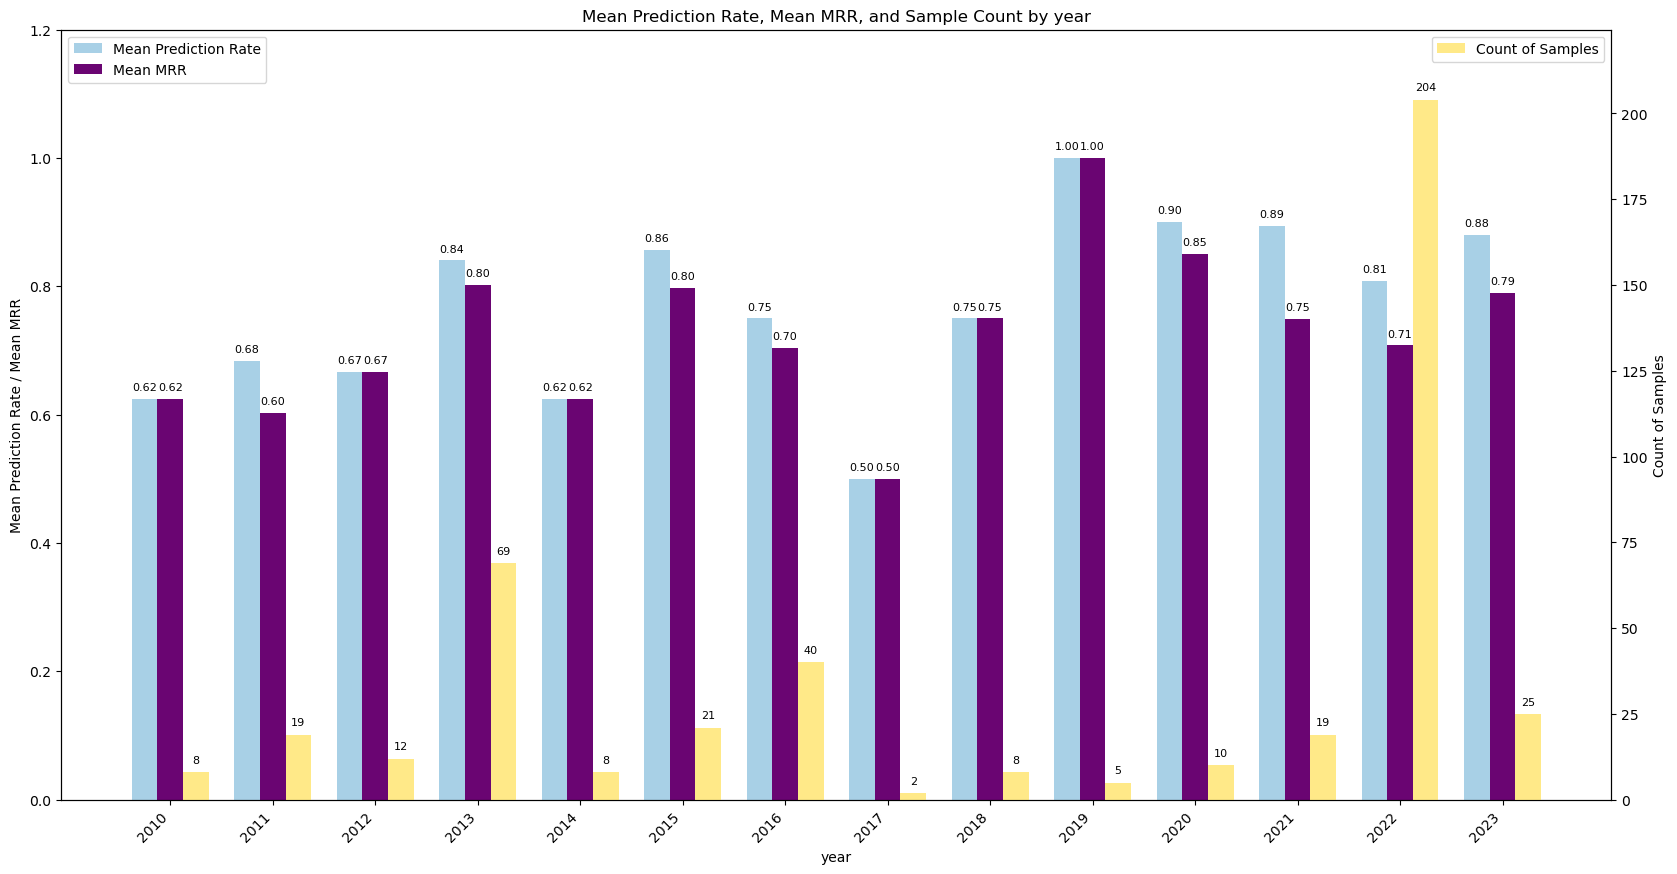

-------------------------------------------------- word_count_buckets --------------------------------------------------


/var/folders/rx/3t2jtk8j69j_db_cydq_v6wc0000gn/T/ipykernel_30872/3779025918.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance = model_1.groupby([col]).agg(mean_prediction=("is_hit", "mean"),mean_mrr=("mrr", "mean"), count=("is_hit", "count")).reset_index()


,word_count_buckets,mean_prediction,mean_mrr,count
7,"(9000, 10500]",1.000000,1.000000,1
8,"(10500, 12000]",1.000000,1.000000,2
9,"(12000, 15270]",1.000000,0.666667,2
4,"(4500, 6000]",0.866667,0.822222,15
2,"(1500, 3000]",0.862500,0.825000,80
6,"(7500, 9000]",0.833333,0.833333,6
3,"(3000, 4500]",0.809524,0.791667,42
1,"(50, 1500]",0.795122,0.722520,205
5,"(6000, 7500]",0.777778,0.777778,9
0,"(0, 50]",0.750000,0.597727,88


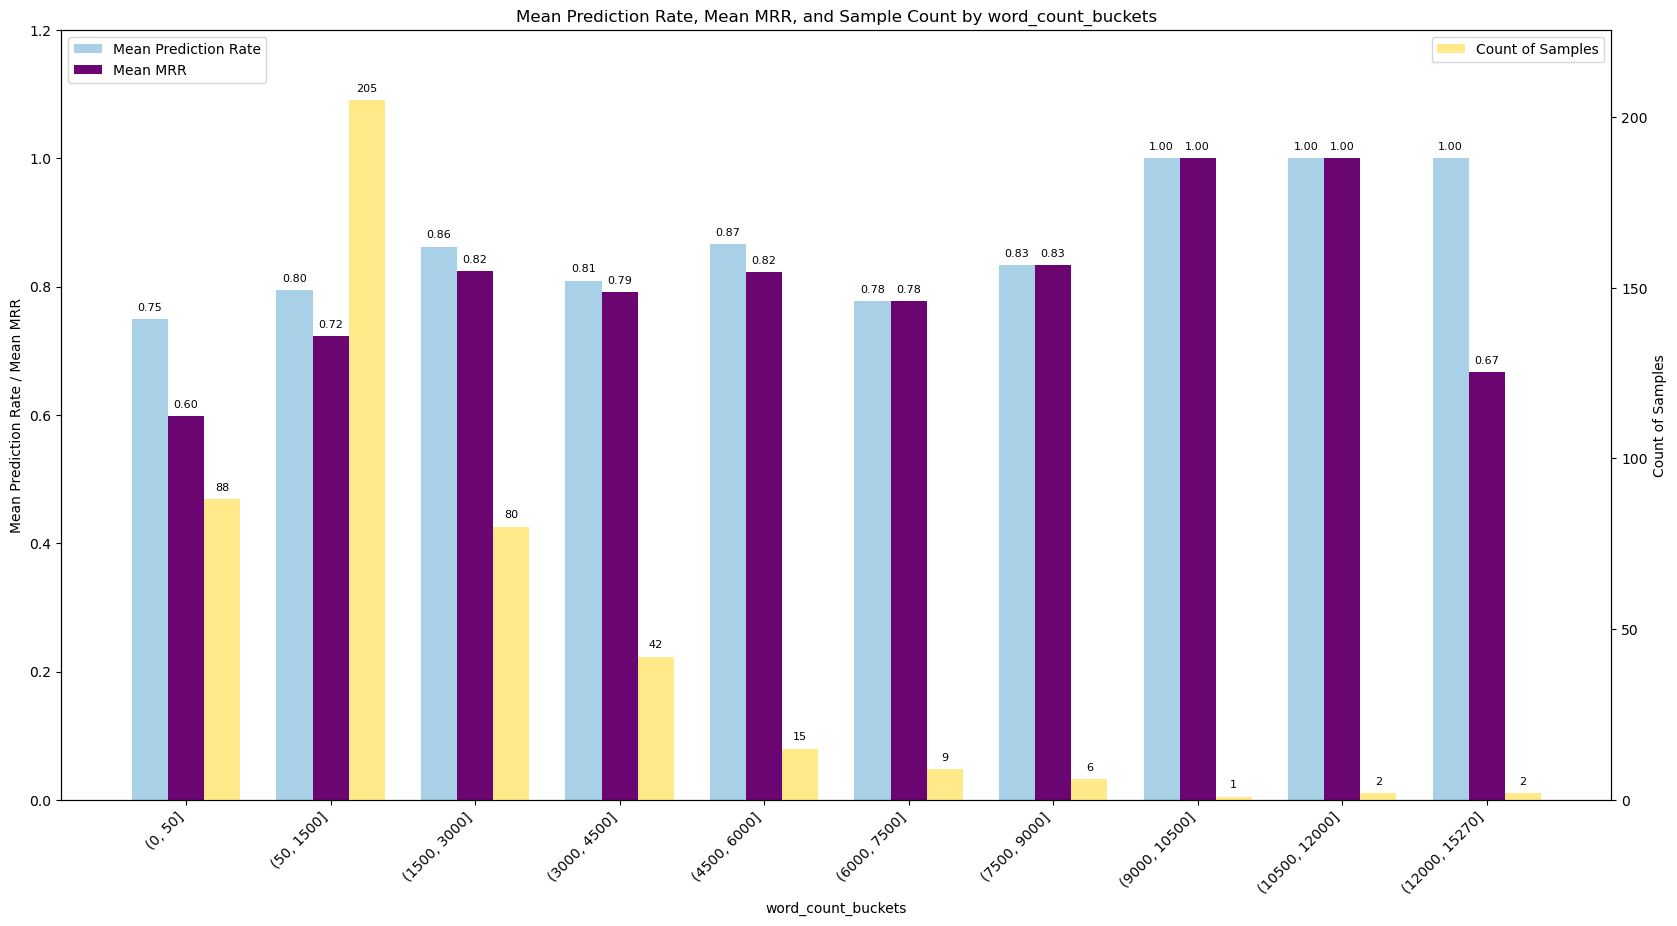

-------------------------------------------------- opinion_source --------------------------------------------------


,opinion_source,mean_prediction,mean_mrr,count
0,opinion_html,1.000000,1.000000,1
3,opinion_plain_text,0.833333,0.719444,18
4,opinion_xml_harvard,0.823529,0.725980,238
2,opinion_html_with_citations,0.777778,0.738448,189
1,opinion_html_columbia,0.750000,0.583333,4


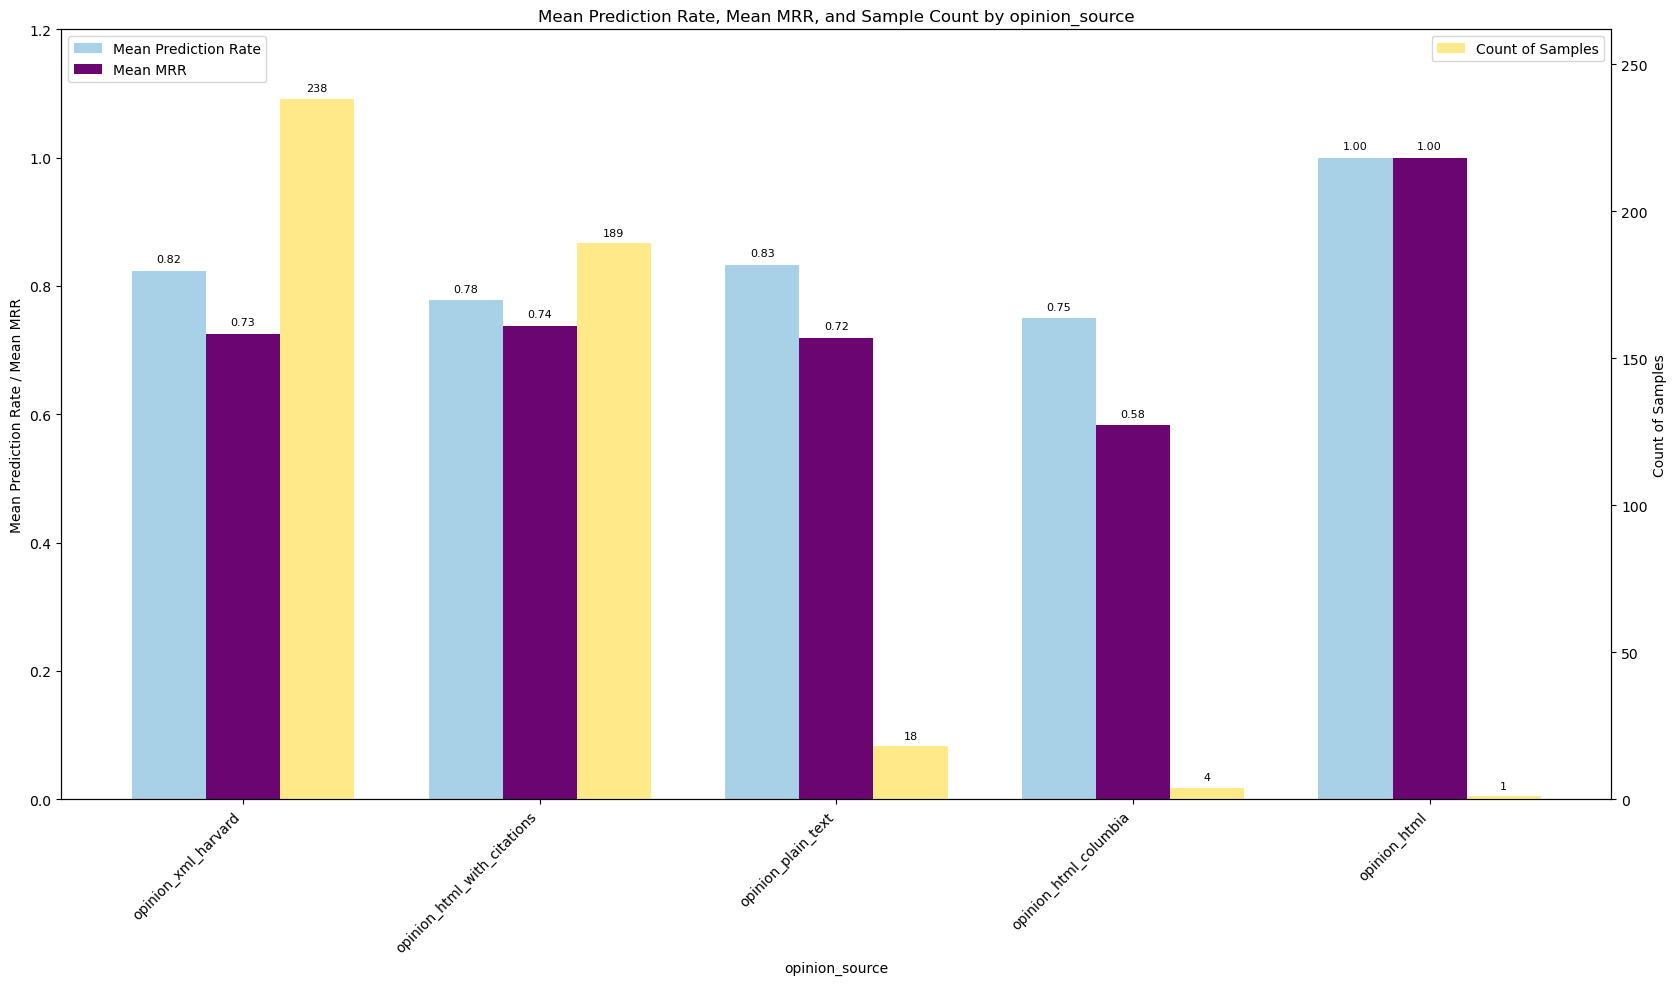

-------------------------------------------------- opinion_type --------------------------------------------------


,opinion_type,mean_prediction,mean_mrr,count
3,035concurrenceinpart,1.000000,0.750000,2
5,050addendum,1.000000,1.000000,1
4,040dissent,0.833333,0.833333,12
1,020lead,0.817427,0.715560,241
0,010combined,0.786885,0.741439,183
2,030concurrence,0.727273,0.727273,11


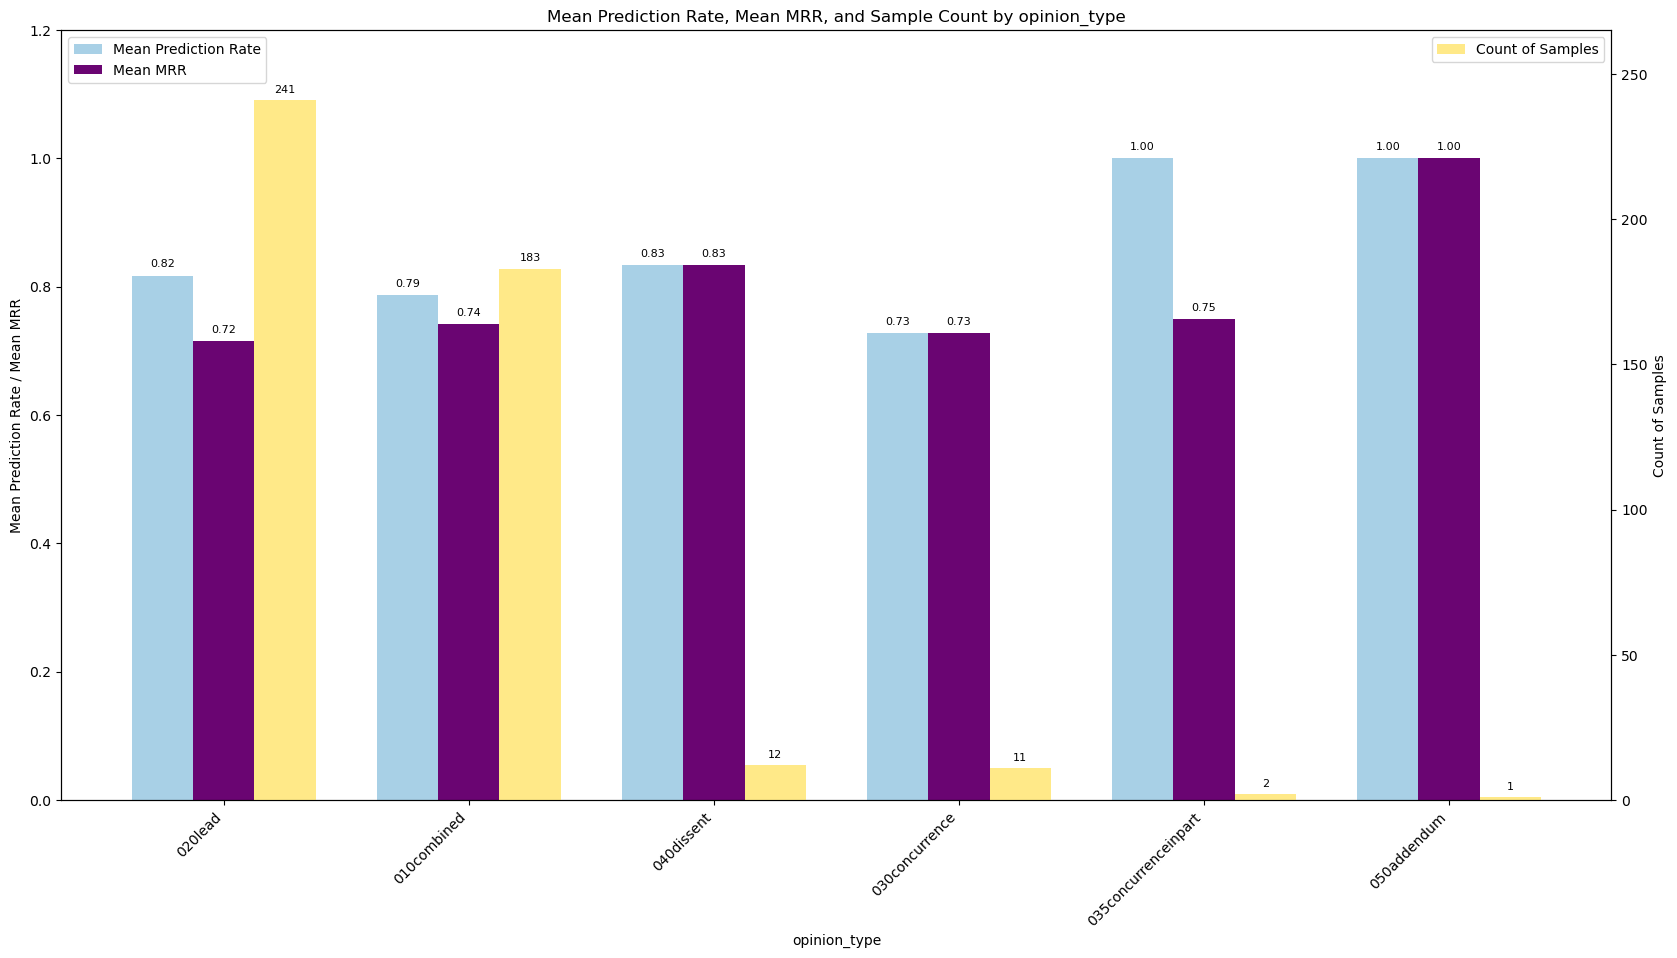

-------------------------------------------------- court_grouped --------------------------------------------------


,court_grouped,mean_prediction,mean_mrr,count
13,ohioctapp,1.000000,1.000000,7
6,fladistctapp,1.000000,0.854545,11
8,la,0.888889,0.888889,9
15,pa,0.888889,0.888889,9
18,texapp,0.882353,0.808824,17
7,illappct,0.857143,0.857143,7
20,wis,0.833333,0.750000,6
19,wash,0.833333,0.666667,6
9,lactapp,0.833333,0.833333,6
14,other,0.830435,0.781594,230


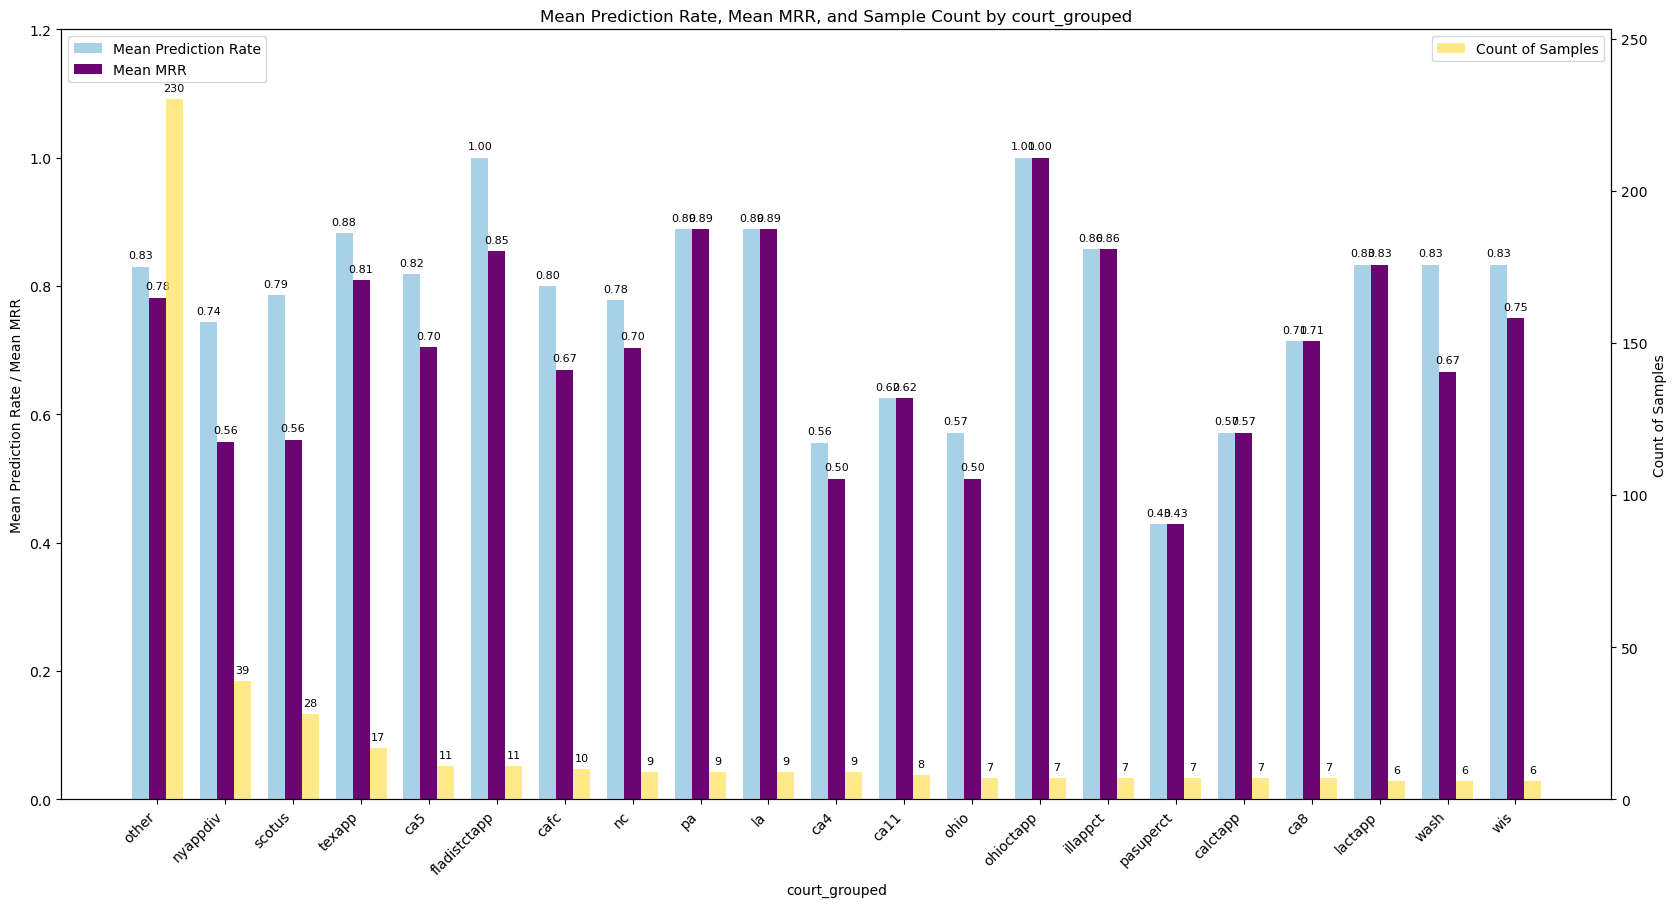

-------------------------------------------------- court_jurisdiction --------------------------------------------------


,court_jurisdiction,mean_prediction,mean_mrr,count
1,FB,1.000000,1.000000,1
4,MA,1.000000,1.000000,1
7,SAG,1.000000,1.000000,2
9,TRA,1.000000,1.000000,1
8,ST,0.937500,0.906250,16
5,S,0.857143,0.800376,133
6,SA,0.798701,0.717857,154
2,FD,0.772727,0.742424,22
0,F,0.738318,0.631308,107
3,FS,0.727273,0.659091,11


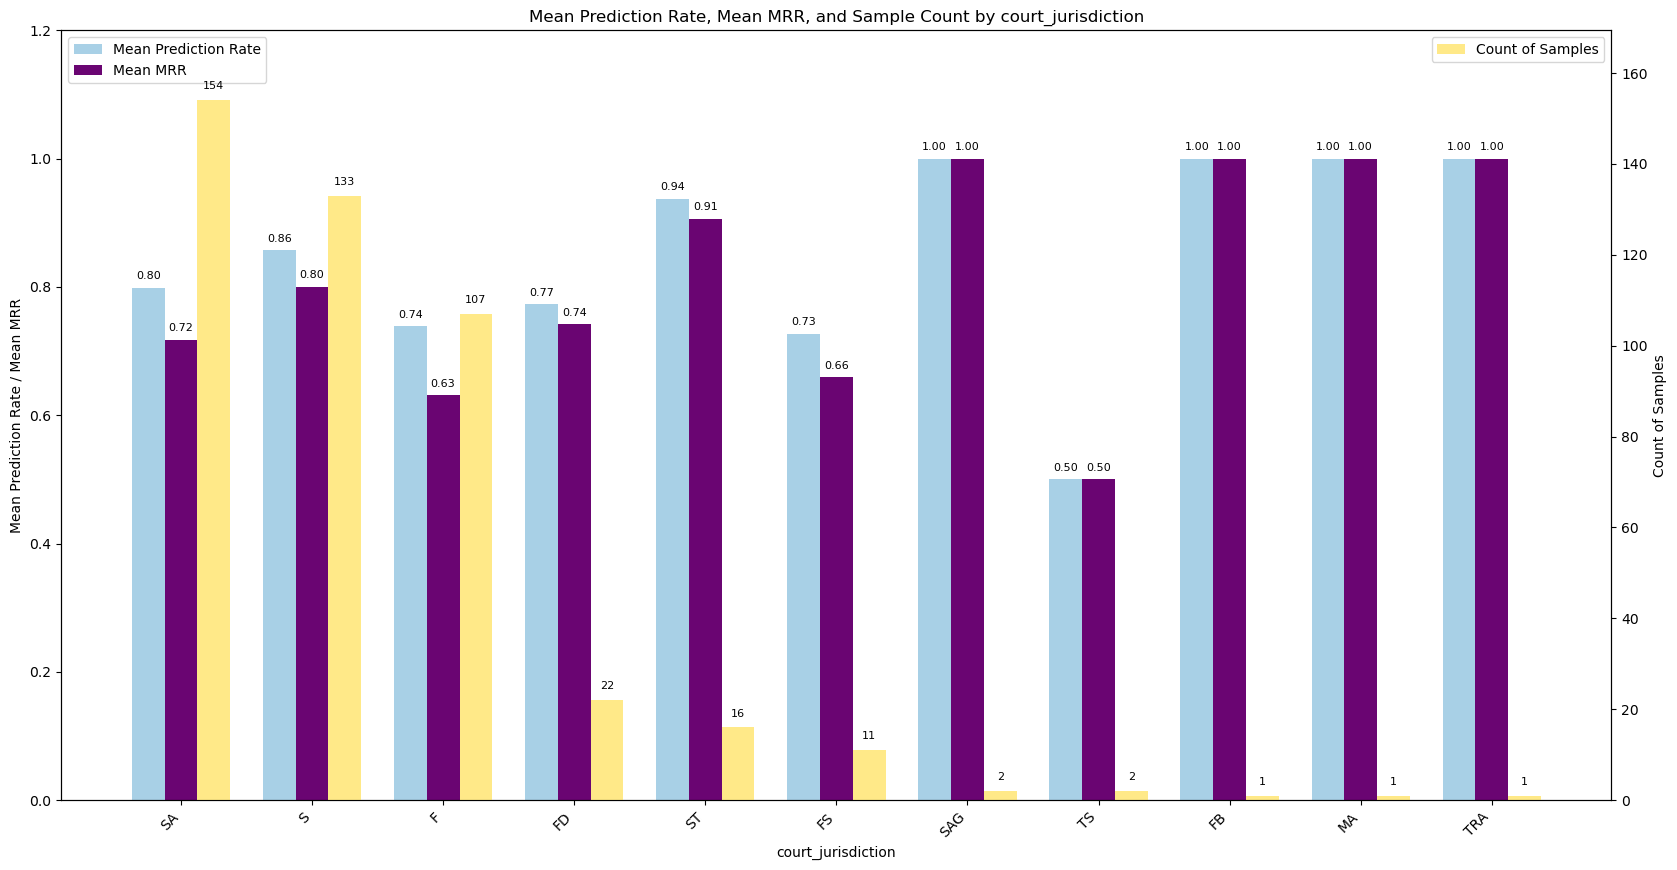

In [7]:
print("MODEL: multi-qa-mpnet-base-dot-v1. CHUNK_SIZE: 512")
for col in ["year", "word_count_buckets", "opinion_source", "opinion_type", "court_grouped", "court_jurisdiction"]:
    print("-"*50, col, "-"*50)
    performance = model_1.groupby([col]).agg(mean_prediction=("is_hit", "mean"),mean_mrr=("mrr", "mean"), count=("is_hit", "count")).reset_index()
    display(performance.sort_values("mean_prediction", ascending=False))
    if col == "year":
        plot_aggregated_data(performance.sort_values(col), col)
    elif col == "word_count_buckets":
        plot_aggregated_data(performance.sort_values("word_count_buckets"), col)
    else:
        plot_aggregated_data(performance.sort_values("count", ascending=False), col)

# Results from `nomic-ai/nomic-embed-text-v1`

MODEL: nomic-ai/nomic-embed-text-v1. CHUNK_SIZE: 8192
-------------------------------------------------- year --------------------------------------------------


,year,mean_prediction,mean_mrr,count
7,2017,1.000000,0.750000,2
9,2019,1.000000,0.900000,5
11,2021,0.947368,0.894737,19
13,2023,0.920000,0.866667,25
5,2015,0.904762,0.811111,21
10,2020,0.900000,0.825000,10
0,2010,0.875000,0.697917,8
8,2018,0.875000,0.812500,8
12,2022,0.867647,0.792239,204
3,2013,0.840580,0.771739,69


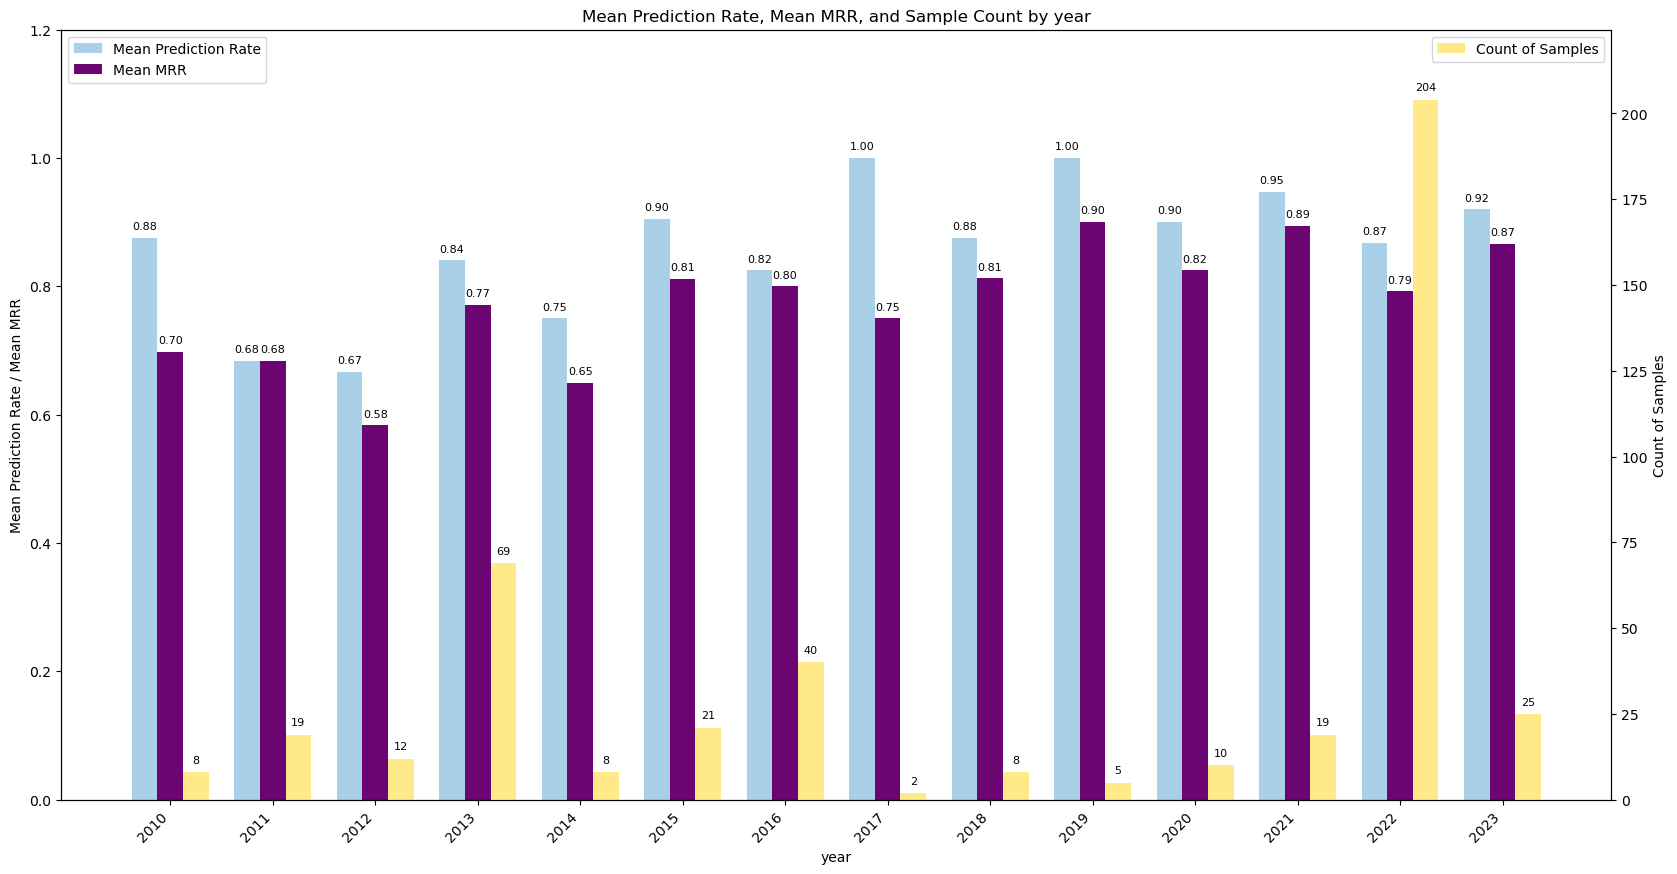

-------------------------------------------------- word_count_buckets --------------------------------------------------


/var/folders/rx/3t2jtk8j69j_db_cydq_v6wc0000gn/T/ipykernel_30872/2338241483.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance = model_2.groupby([col]).agg(mean_prediction=("is_hit", "mean"),mean_mrr=("mrr", "mean"), count=("is_hit", "count")).reset_index()


,word_count_buckets,mean_prediction,mean_mrr,count
7,"(9000, 10500]",1.000000,1.000000,1
8,"(10500, 12000]",1.000000,0.750000,2
4,"(4500, 6000]",0.933333,0.805556,15
1,"(50, 1500]",0.897561,0.830813,205
5,"(6000, 7500]",0.888889,0.833333,9
2,"(1500, 3000]",0.887500,0.811875,80
6,"(7500, 9000]",0.833333,0.833333,6
3,"(3000, 4500]",0.785714,0.755952,42
0,"(0, 50]",0.750000,0.670455,88
9,"(12000, 15270]",0.500000,0.500000,2


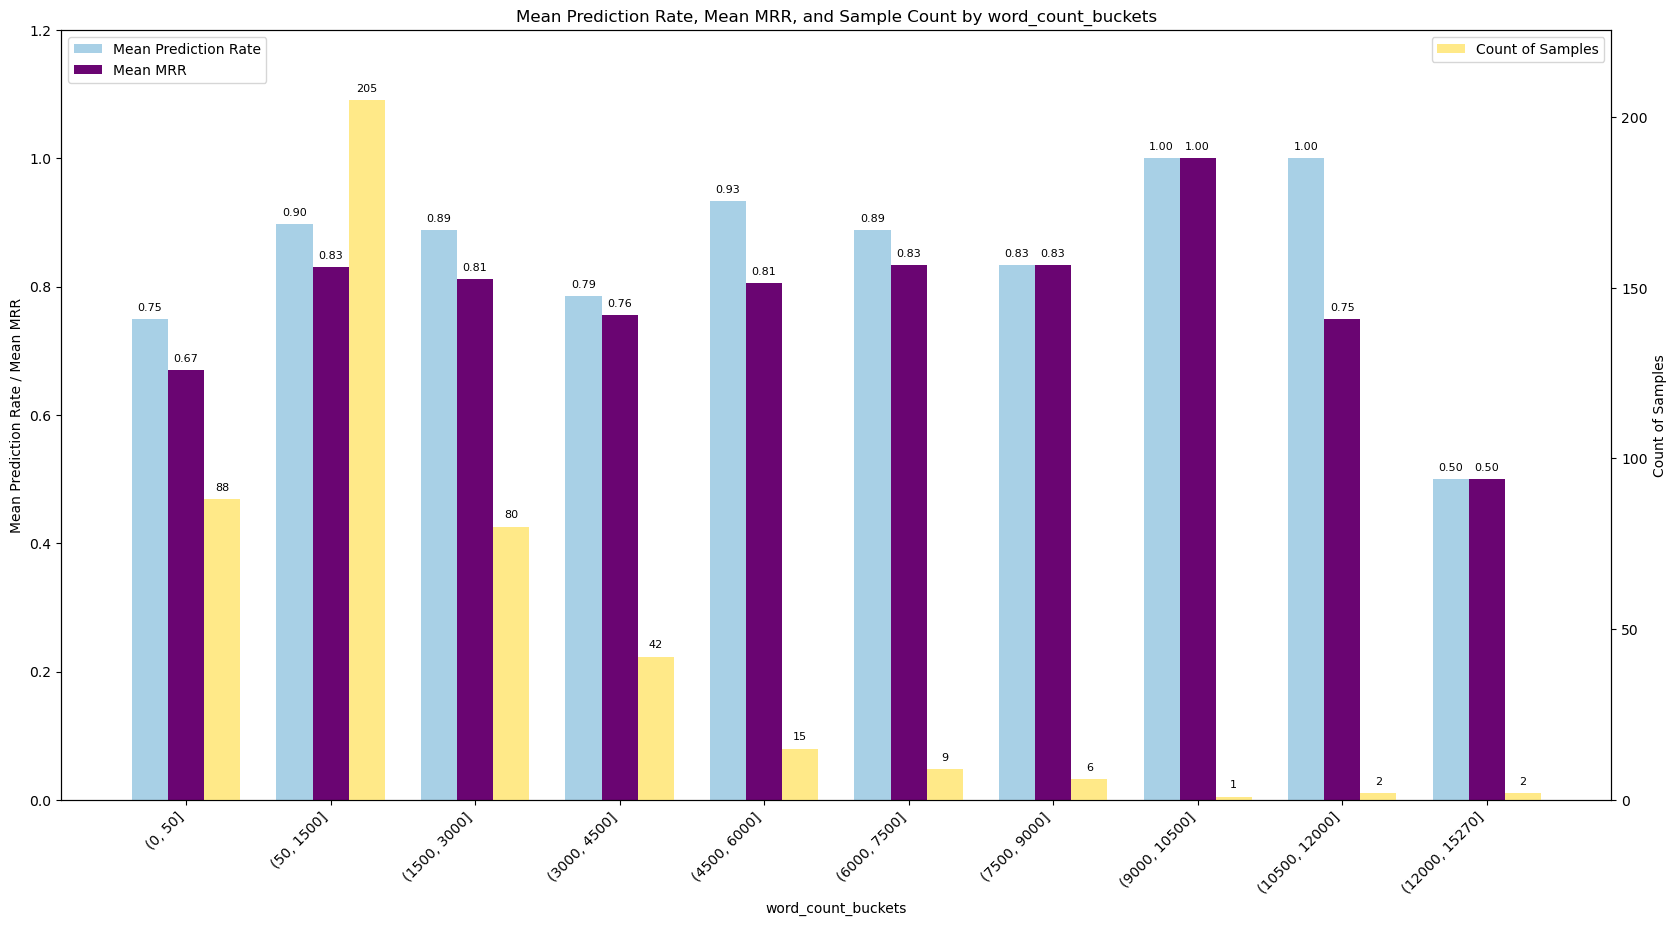

-------------------------------------------------- opinion_source --------------------------------------------------


,opinion_source,mean_prediction,mean_mrr,count
0,opinion_html,1.000000,1.000000,1
1,opinion_html_columbia,1.000000,1.000000,4
3,opinion_plain_text,0.888889,0.844444,18
4,opinion_xml_harvard,0.878151,0.803711,238
2,opinion_html_with_citations,0.820106,0.754586,189


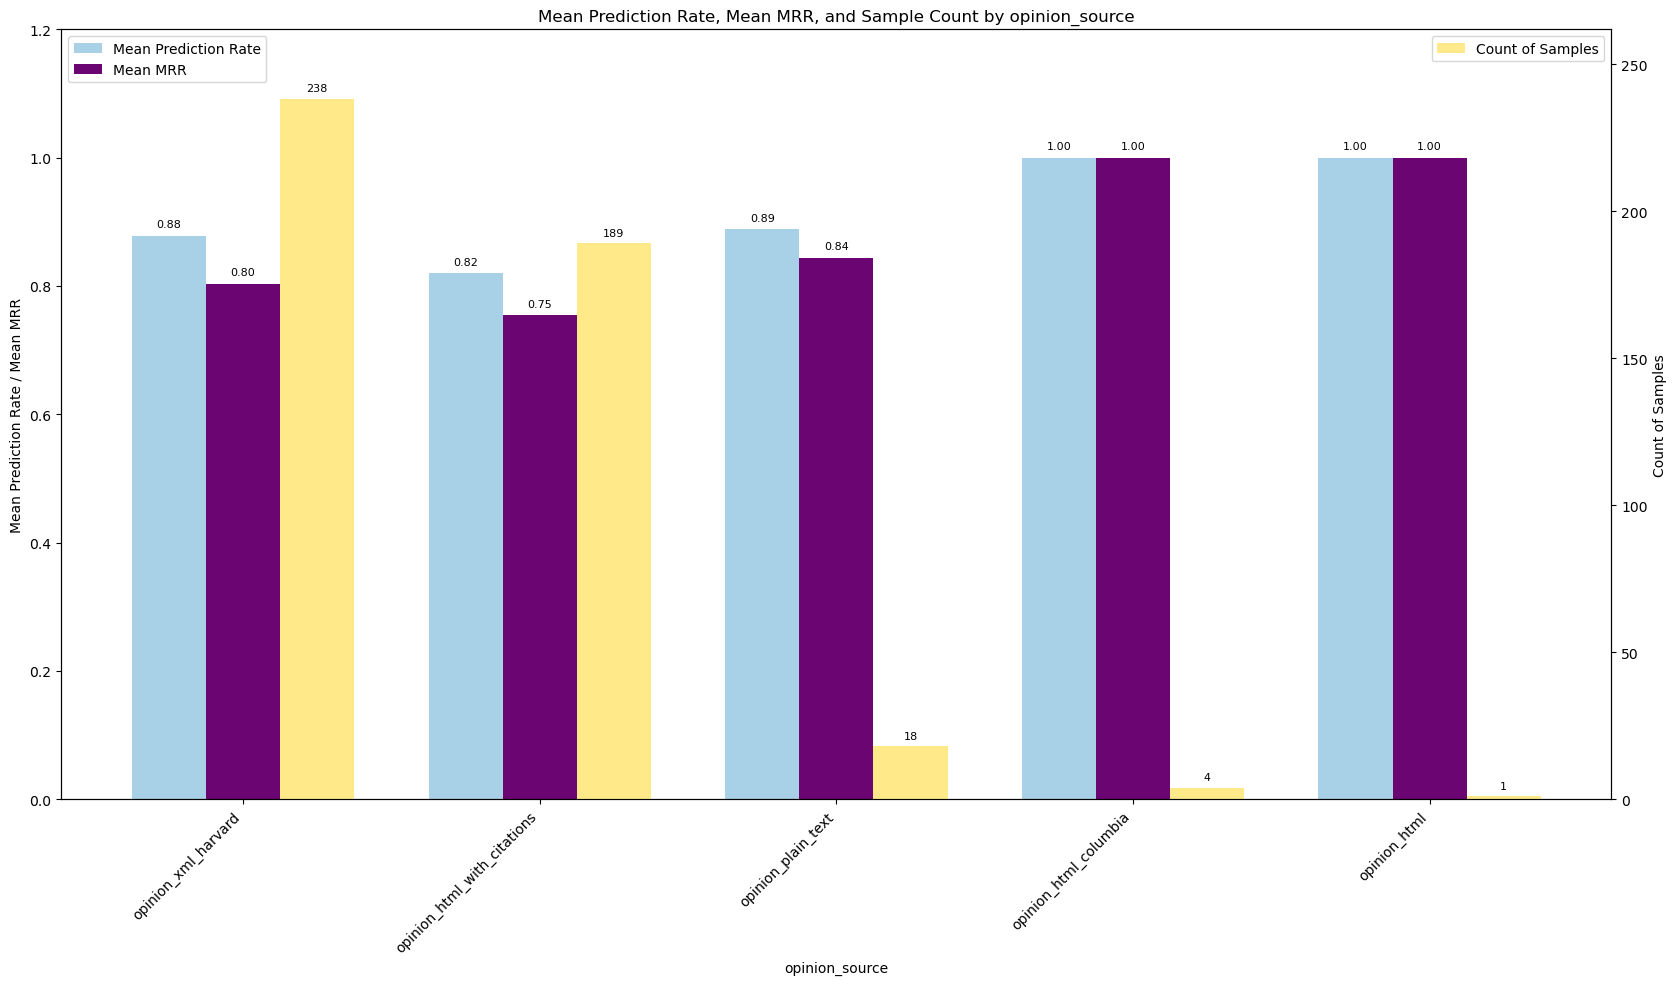

-------------------------------------------------- opinion_type --------------------------------------------------


,opinion_type,mean_prediction,mean_mrr,count
3,035concurrenceinpart,1.000000,1.000000,2
4,040dissent,1.000000,0.944444,12
5,050addendum,1.000000,1.000000,1
1,020lead,0.871369,0.796473,241
0,010combined,0.825137,0.758561,183
2,030concurrence,0.818182,0.818182,11


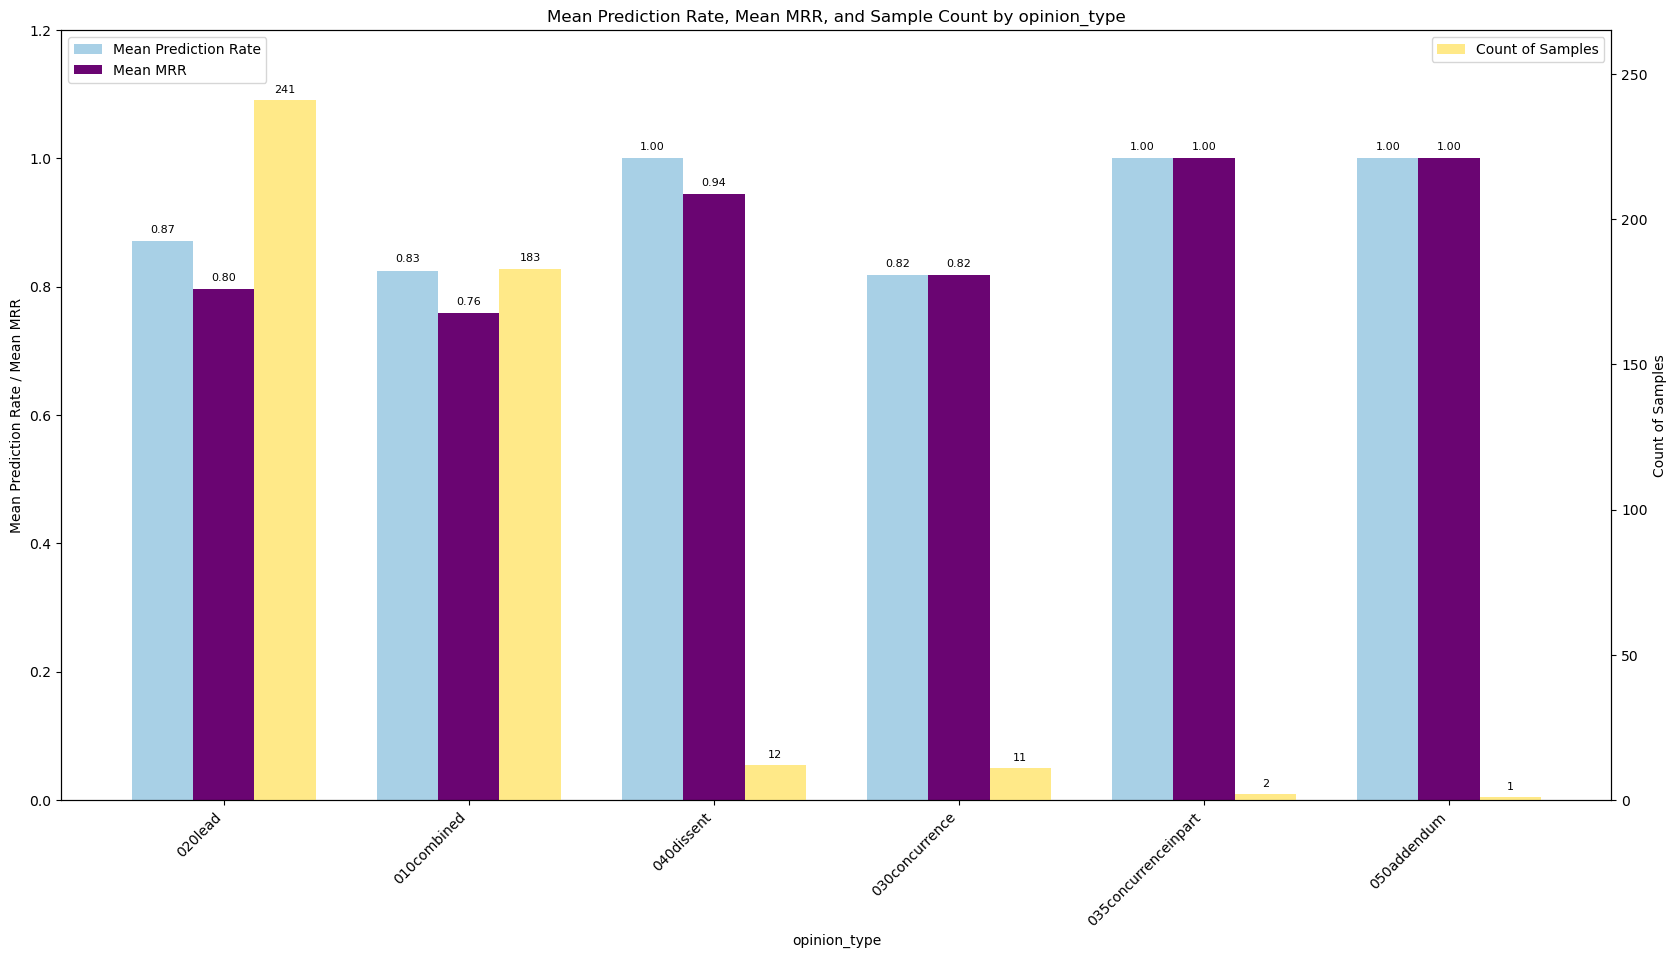

-------------------------------------------------- court_grouped --------------------------------------------------


,court_grouped,mean_prediction,mean_mrr,count
20,wis,1.000000,0.888889,6
8,la,1.000000,1.000000,9
15,pa,1.000000,0.944444,9
13,ohioctapp,1.000000,0.928571,7
9,lactapp,1.000000,0.916667,6
2,ca5,0.909091,0.909091,11
10,nc,0.888889,0.888889,9
18,texapp,0.882353,0.735294,17
14,other,0.865217,0.814275,230
7,illappct,0.857143,0.785714,7


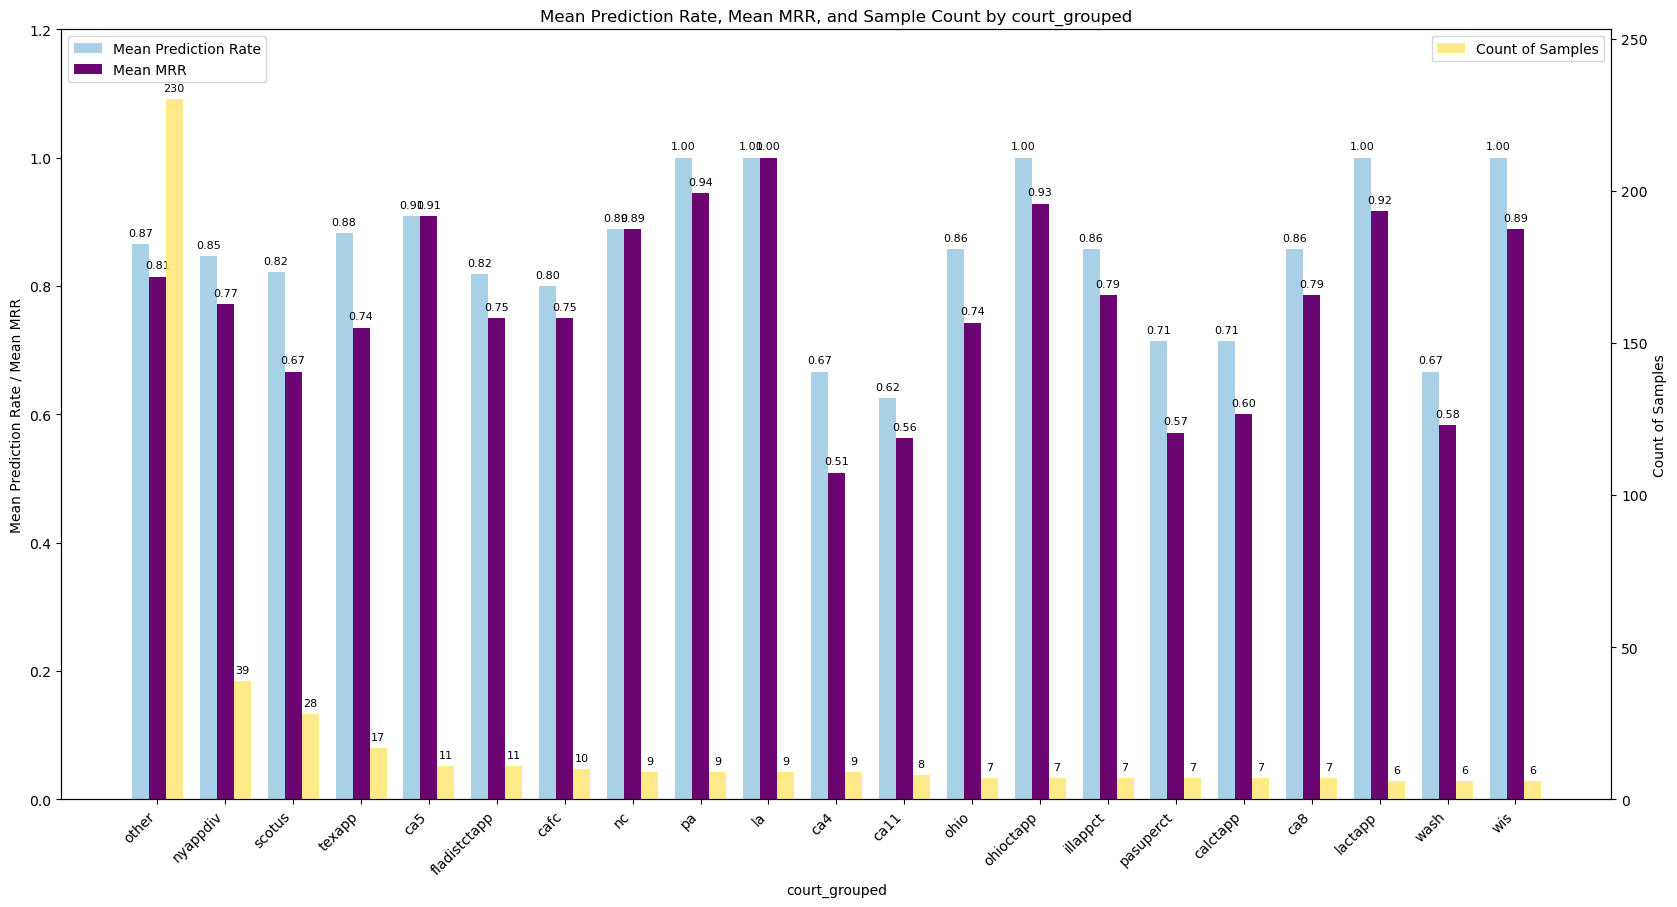

-------------------------------------------------- court_jurisdiction --------------------------------------------------


,court_jurisdiction,mean_prediction,mean_mrr,count
1,FB,1.000000,1.000000,1
4,MA,1.000000,1.000000,1
7,SAG,1.000000,1.000000,2
9,TRA,1.000000,1.000000,1
8,ST,0.937500,0.937500,16
5,S,0.924812,0.858647,133
6,SA,0.857143,0.783983,154
0,F,0.785047,0.707944,107
2,FD,0.772727,0.719697,22
3,FS,0.727273,0.598485,11


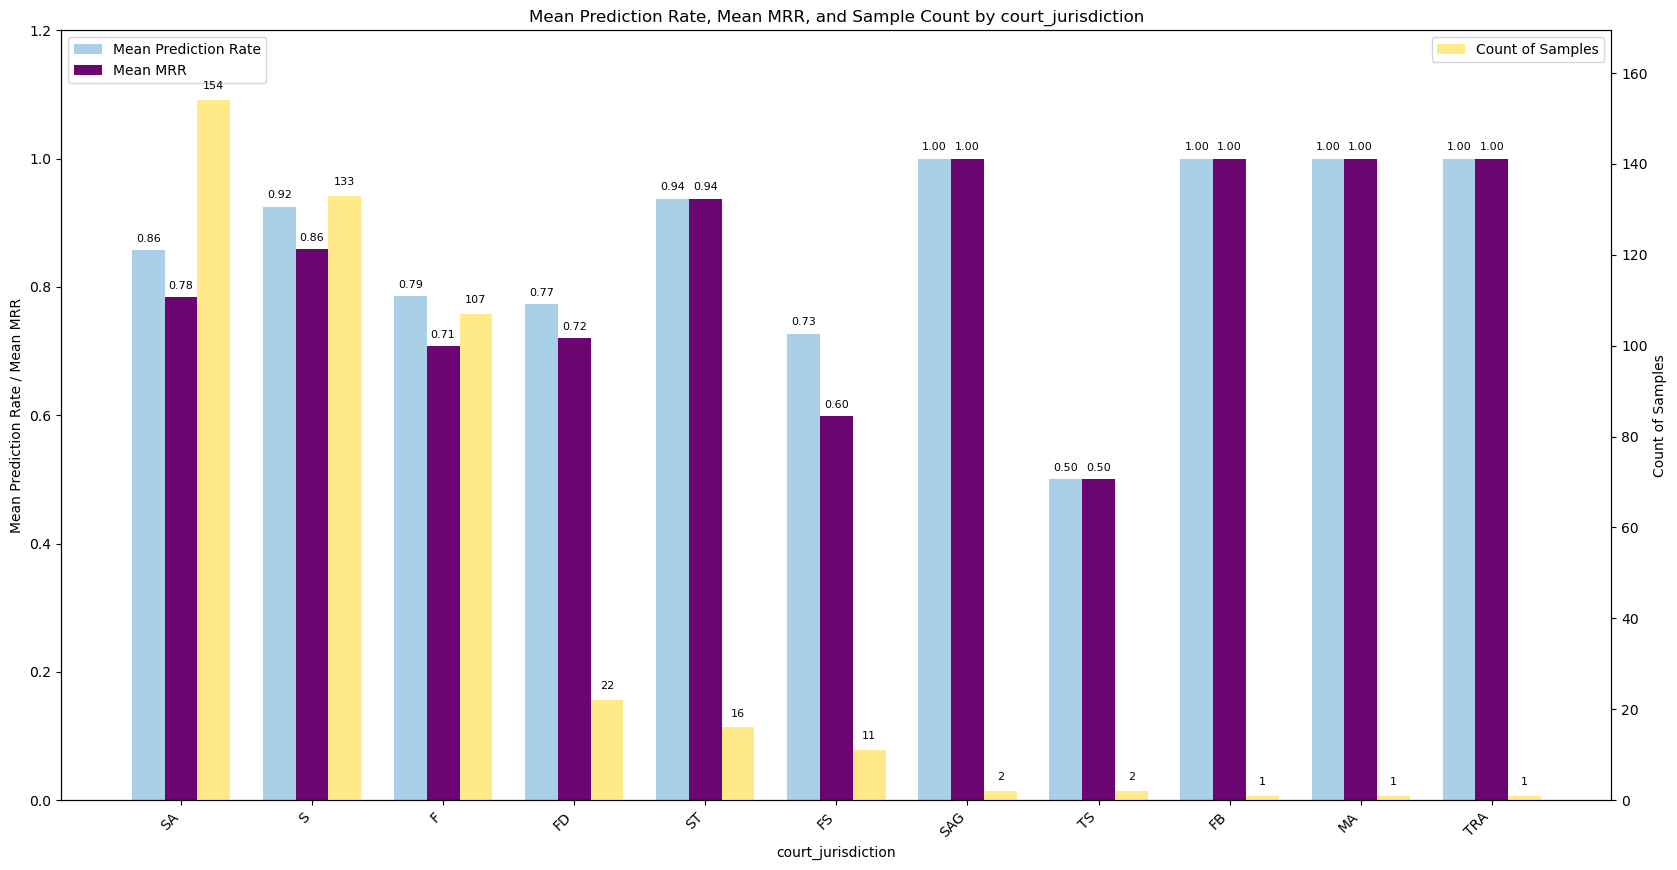

In [8]:
print("MODEL: nomic-ai/nomic-embed-text-v1. CHUNK_SIZE: 8192")
for col in ["year", "word_count_buckets", "opinion_source", "opinion_type", "court_grouped", "court_jurisdiction"]:
    print("-"*50, col, "-"*50)
    performance = model_2.groupby([col]).agg(mean_prediction=("is_hit", "mean"),mean_mrr=("mrr", "mean"), count=("is_hit", "count")).reset_index()
    display(performance.sort_values("mean_prediction", ascending=False))
    if col == "year":
        plot_aggregated_data(performance.sort_values(col), col)
    elif col == "word_count_buckets":
        plot_aggregated_data(performance.sort_values("word_count_buckets"), col)
    else:
        plot_aggregated_data(performance.sort_values("count", ascending=False), col)